# EC2B1 Coursework -- Portugal and South Africa
*Andres Oats Garcia, Emma Staveley-Wadham, Omar Pozder, Shounak Pal, Tom Baldwin*



In [244]:
#import modules
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import seaborn as sns #for nicer plots
from sklearn.linear_model import LinearRegression #to retrieve regression coefficients

from plotnine import ggplot, aes, geom_line


#set up seaborn
sns.set_theme()
sns.set_palette('Dark2') #Dark2, PuOr, RdBu


In [245]:
#import dataset
data = pd.read_excel('pwt100.xlsx', sheet_name = 'Data', header = 0)
data.head()

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [246]:
#cleaning data

#filtering only the relevant columns
df = data.loc[:, ("country", "year", "rgdpe", "pop")]

#calculating real GDP per capita
df["rgdpe_pc"] = df["rgdpe"] / df["pop"]

#filtering our countries
countries = ["Portugal", "South Africa"]
df = df.loc[df["country"].isin(countries), ("country","year", "rgdpe_pc", "rgdpe")]

df = df.reset_index(drop = True)

#calculate logs of rgdpe and rgdpe_pc
df["log_rgdpe"] = df["rgdpe"].apply(np.log)
df["log_rgdpe_pc"] = df["rgdpe_pc"].apply(np.log)



In [247]:
df.head()

,country,year,rgdpe_pc,rgdpe,log_rgdpe,log_rgdpe_pc
0,Portugal,1950,2958.938967,23896.437500,10.081485,7.992586
1,Portugal,1951,3239.131497,26306.451172,10.177569,8.083061
2,Portugal,1952,3338.838936,27230.558594,10.212095,8.113378
3,Portugal,1953,3535.441631,29012.892578,10.275496,8.170594
4,Portugal,1954,3703.070578,30576.775391,10.327996,8.216918


## Section 1: Trend Calculation

We compute the following trend time paths using `scikit-learn` to compute regression coefficients. 

We have used these different specifications for robustness reasons. The additive models use the levels when calculating the trend, whereas the exponential models use the log levels to calculate the trend.



1.   Additive, linear trend (see `get_trend_path_add_lin`), i.e. $$y = \beta_0 + \beta_1 t$$
2.   Additive, quadtratic trend (see `get_trend_path_add_quad`),  i.e. $$y = \beta_0 + \beta_1 t + \beta_2 t^2$$  
3.   Exponential, linear trend (see `get_trend_path_exp_lin`), i.e $$log ~y = \beta_0 + \beta_1 t ~\text{  i.e. }~ y = \text{exp}(\beta_0 + \beta_1 t)$$ 
4.   Exponential, quadratic trend (see `get_trend_path_exp_quad`),  i.e. $$log ~y = \beta_0 + \beta_1 t + \beta_2 t^2  ~\text{  i.e.  }~ y = \text{exp}(\beta_0 + \beta_1 t + \beta_2 t^2)$$ 

where $y$ denotes either `rgdpe` or `rgedpe_pc`. 

For each trend model and country, we plot below log real gdp and log real gdp per capita, with their respective trends.

### Creating functions for each regression type:
We create a function for each regression type that returns the fitted trend values. 

In [248]:
# (1) creating a function that calculates the additive, linear trend path:

def get_trend_path_add_lin(df, column, country):
  '''
    Calculates the additive linear trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #generate arrays of time
  x1 = np.arange(1,T+1,1).reshape(-1, 1)  # reshape to create a column vector

  model = LinearRegression() #set the model to be an OLS regression

  #fit the linear regression model
  model.fit(x1,y)

  #set the coefficients to be beta_1 and beta_2
  beta_1 = model.coef_
  beta_0 = model.intercept_

  y_trend = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend[t] = beta_0 + beta_1 * (t + 1)

  return y_trend


In [249]:
# (2) creating a function that calculates the additive, quadratic trend path:

def get_trend_path_add_quad(df, column, country):
  '''
    Calculates the additive quadratic trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #generate arrays of time and time squared
  x1 = np.arange(1,T+1,1)
  x2 = np.square(x1)

  #combine these arrays into a dataframe
  X = pd.DataFrame({"x1": x1, "x2":x2})

  model = LinearRegression()

  #fit the linear regression model
  model.fit(X,y)

  #set the coefficients to be beta_1 and beta_2
  beta_1, beta_2 = model.coef_
  beta_0 = model.intercept_

  y_trend = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend[t] = beta_0 + beta_1 * (t + 1)  + (beta_2) * ((t+1) **2)

  return y_trend

In [250]:
# (3) creating a function that calculates the exponential, linear trend path:

def get_trend_path_exp_lin(df, column, country):
  '''
    Calculates the exponential linear trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #generate arrays of time
  x1 = np.arange(1,T+1,1).reshape(-1, 1)  # reshape to create a column vector


  model = LinearRegression()

  #fit the linear regression model
  model.fit(x1,np.log(y)) #take the natural log of y for the exponential fit

  #set the coefficients to be beta_1 and beta_2
  beta_1 = model.coef_
  beta_0 = model.intercept_

  y_trend_log = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend_log[t] = beta_0 + beta_1 * (t + 1)

  return np.exp(y_trend_log)

In [251]:
# (4) creating a function that calculates the exponential, quadratic trend path:

def get_trend_path_exp_quad(df, column, country):
  '''
    Calculates the exponential quadratic trend path of a given column

    Returns the trend path as a numpy array
  '''

  #set the dependent variable as y
  y = df.loc[df["country"]==country, column]
  T = len(y)

  #array that measures the time and time squared
  x1 = np.arange(1,T+1,1)
  x2 = np.square(x1)

  #combine these arrays into a dataframe
  X = pd.DataFrame({"x1": x1, "x2":x2})

  model = LinearRegression()

  #fit the linear regression model
  model.fit(X,np.log(y)) #take the natural log of y for the exponential fit

  #set the coefficients to be beta_1 and beta_2
  beta_1, beta_2 = model.coef_
  beta_0 = model.intercept_

  y_trend_log = np.empty(T)

  #compute trend for all years
  for t in range(T):
      y_trend_log[t] = beta_0 + beta_1 * (t + 1)  + (beta_2) * ((t+1) **2)

  return np.exp(y_trend_log)

### Portugal

#### Creating the plot for log of real GDP in Portugal

/var/folders/lr/ypfppkt17sz0nz12x8ds06zw0000gn/T/ipykernel_65879/2832422373.py:10: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

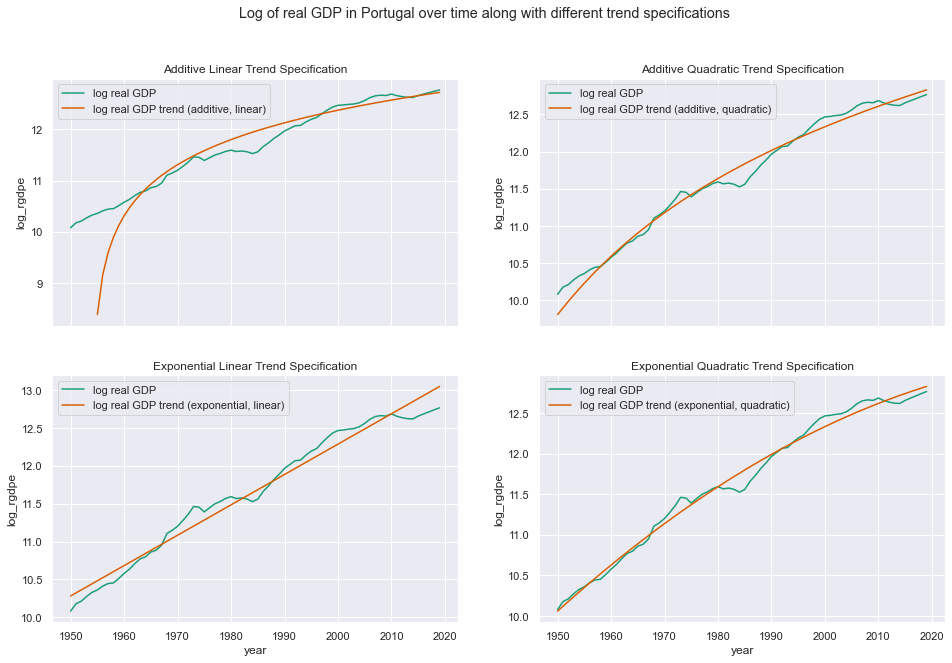

In [252]:
#log real gdp

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP in Portugal over time along with different trend specifications")

df2 = df.loc[df["country"] == "Portugal", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
df2["rgdpe_log_trend_add_lin"] = np.log(get_trend_path_add_lin(df2, "rgdpe", "Portugal")) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin", label="log real GDP trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
df2["rgdpe_log_trend_add_quad"] = np.log(get_trend_path_add_quad(df2, "rgdpe", "Portugal"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad", label="log real GDP trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
df2["rgdpe_log_trend_exp_lin"] = np.log(get_trend_path_exp_lin(df2, "rgdpe", "Portugal"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin", label="log real GDP trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
df2["rgdpe_log_trend_exp_quad"] = np.log(get_trend_path_exp_quad(df2, "rgdpe", "Portugal"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad", label="log real GDP trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

#### Creating the plot for log of real GDP per capita in Portugal

/var/folders/lr/ypfppkt17sz0nz12x8ds06zw0000gn/T/ipykernel_65879/893589193.py:10: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

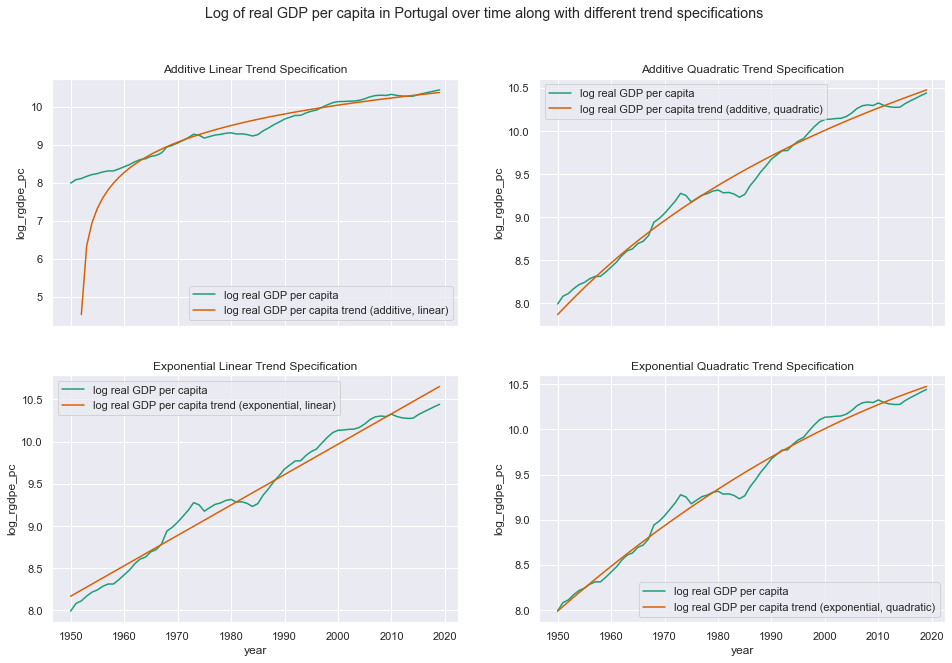

In [253]:
#log real gdp per capita

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP per capita in Portugal over time along with different trend specifications")

df2 = df.loc[df["country"] == "Portugal", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
df2["rgdpe_log_trend_add_lin_pc"] = np.log(get_trend_path_add_lin(df2, "rgdpe_pc", "Portugal")) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin_pc", label="log real GDP per capita trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
df2["rgdpe_log_trend_add_quad_pc"] = np.log(get_trend_path_add_quad(df2, "rgdpe_pc", "Portugal"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad_pc", label="log real GDP per capita trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
df2["rgdpe_log_trend_exp_lin_pc"] = np.log(get_trend_path_exp_lin(df2, "rgdpe_pc", "Portugal"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin_pc", label="log real GDP per capita trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
df2["rgdpe_log_trend_exp_quad_pc"] = np.log(get_trend_path_exp_quad(df2, "rgdpe_pc", "Portugal"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad_pc", label="log real GDP per capita trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

### South Africa

#### Creating the plot for log of real GDP for South Africa

/var/folders/lr/ypfppkt17sz0nz12x8ds06zw0000gn/T/ipykernel_65879/2750586967.py:10: RuntimeWarning: invalid value encountered in log


Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

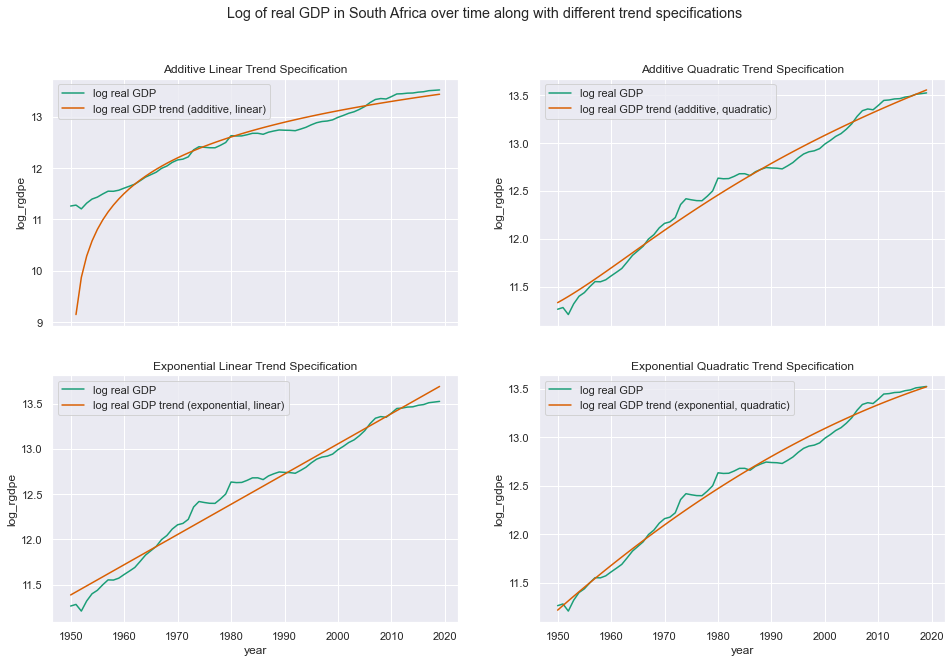

In [254]:
#log real gdp

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP in South Africa over time along with different trend specifications")

df2 = df.loc[df["country"] == "South Africa", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
df2["rgdpe_log_trend_add_lin"] = np.log(get_trend_path_add_lin(df2, "rgdpe", "South Africa")) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin", label="log real GDP trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
df2["rgdpe_log_trend_add_quad"] = np.log(get_trend_path_add_quad(df2, "rgdpe", "South Africa"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad", label="log real GDP trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
df2["rgdpe_log_trend_exp_lin"] = np.log(get_trend_path_exp_lin(df2, "rgdpe", "South Africa"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin", label="log real GDP trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
df2["rgdpe_log_trend_exp_quad"] = np.log(get_trend_path_exp_quad(df2, "rgdpe", "South Africa"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe", label="log real GDP ", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad", label="log real GDP trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

#### Creating the plot for log of real GDP per capita for South Africa

Text(0.5, 1.0, 'Exponential Quadratic Trend Specification')

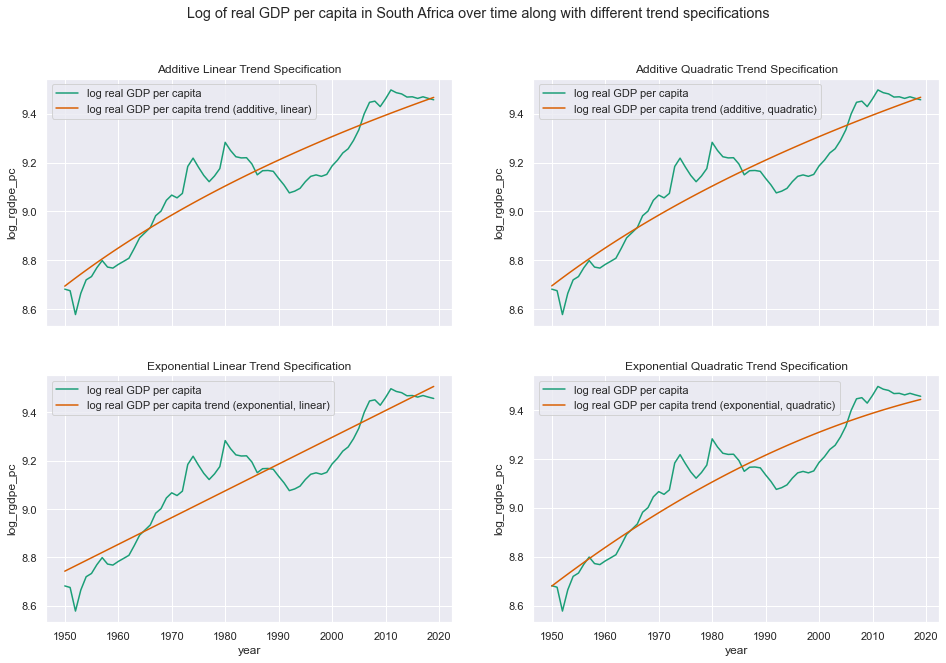

In [255]:
#log real gdp per capita

fig, axes = plt.subplots(2,2, sharex=True, figsize=(16,10))
fig.suptitle("Log of real GDP per capita in South Africa over time along with different trend specifications")

df2 = df.loc[df["country"] == "South Africa", ('country', 'year', 'rgdpe_pc', 'rgdpe', 'log_rgdpe', 'log_rgdpe_pc')]

#additive linear
##find additive linear trend
df2["rgdpe_log_trend_add_lin_pc"] = np.log(get_trend_path_add_lin(df2, "rgdpe_pc", "South Africa")) 

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_lin_pc", label="log real GDP per capita trend (additive, linear)", ax=axes[0,0])
axes[0,0].set_title("Additive Linear Trend Specification")

#additive quadratic 
##find additive quadratic trend
df2["rgdpe_log_trend_add_quad_pc"] = np.log(get_trend_path_add_quad(df2, "rgdpe_pc", "South Africa"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[0,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_add_quad_pc", label="log real GDP per capita trend (additive, quadratic)", ax=axes[0,1])
axes[0,1].set_title("Additive Quadratic Trend Specification")

#exponential linear 
##find exponential linear trend
df2["rgdpe_log_trend_exp_lin_pc"] = np.log(get_trend_path_exp_lin(df2, "rgdpe_pc", "South Africa"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,0])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_lin_pc", label="log real GDP per capita trend (exponential, linear)", ax=axes[1,0])
axes[1,0].set_title("Exponential Linear Trend Specification")

#exponential linear 
##find exponential quadratic trend
df2["rgdpe_log_trend_exp_quad_pc"] = np.log(get_trend_path_exp_quad(df2, "rgdpe_pc", "South Africa"))

##plot 
sns.lineplot(data=df2, x="year", y="log_rgdpe_pc", label="log real GDP per capita", ax=axes[1,1])
sns.lineplot(data=df2, x="year", y="rgdpe_log_trend_exp_quad_pc", label="log real GDP per capita trend (exponential, quadratic)", ax=axes[1,1])
axes[1,1].set_title("Exponential Quadratic Trend Specification")

## Section 2: Extracting a Measure for TFP

We consider two production functions when extracting a measure for TFP:

Standard Cobb Douglas:
$$ Y=A K^\alpha L^\beta$$ 

Human Capital Cobb Douglas:
$$ Y=A K^\alpha L^\beta H^\gamma$$ 


where $Y$ denotes real GDP, $A$ denotes TFP, $K$ denotes capital, $L$ denotes labour and $H$ denotes human capital. $\alpha$, $\beta$ and $\gamma$ are parameters.

Log linearising these production functions we get:

$$y = \lambda + \alpha k + \beta l + log A$$


$$y = \lambda + \alpha k + \beta l + \gamma h + log A$$

with lower case letters representing logs of variables (e.g. $y = log Y$) and $\lambda$ representing an intercept term.

We can extract a measure for TFP by extracting the residuals from regressions  of these log linearised equations. 

The standard cobb douglas production function extracts a measure for TFP, whilst the human capital cobb douglas function extracts a measure for TFP controlling for human capital.

For $Y$ we use `rgdpna` (real gdp), for $K$ we use `rnna` (capital stock at 2017 prices), for $L$ we use `emp` (number of employed workers), and for $H$ we use `hc` (human capital index).

In [266]:
#filtering only the relevant columns
tfp_df = data.loc[:, ("country", "year", "rgdpna", "pop", "rnna", "hc", "emp", "ctfp")]

#filtering our countries
countries = ["Portugal", "South Africa"]
tfp_df = tfp_df.loc[tfp_df["country"].isin(countries), ("country", "year", "rgdpna", "pop", "rnna", "hc", "emp","ctfp")]

tfp_df = tfp_df.reset_index(drop = True)

#calculate logs of rgdpe and rgdpe_pc
tfp_df["log_rgdpna"] = tfp_df["rgdpna"].apply(np.log)
tfp_df["log_rnna"] = tfp_df["rnna"].apply(np.log)
tfp_df["log_hc"] = tfp_df["hc"].apply(np.log)
tfp_df["log_emp"] = tfp_df["emp"].apply(np.log)

tfp_df.head()

,country,year,rgdpna,pop,rnna,hc,emp,ctfp,log_rgdpna,log_rnna,log_hc,log_emp
0,Portugal,1950,32679.031250,8.076016,200970.093750,1.241877,3.048248,NaN,10.394489,12.210911,0.216624,1.114567
1,Portugal,1951,35689.503906,8.121452,208849.187500,1.247894,3.046919,NaN,10.482612,12.249368,0.221457,1.114131
2,Portugal,1952,37142.679688,8.155697,218197.375000,1.253940,3.041210,NaN,10.522522,12.293155,0.226290,1.112256
3,Portugal,1953,39096.964844,8.206299,230241.484375,1.260015,3.041408,NaN,10.573800,12.346884,0.231124,1.112320
4,Portugal,1954,40841.328125,8.257141,241873.718750,1.266120,3.041463,0.72594,10.617450,12.396171,0.235957,1.112339


### Standard Cobb Douglas Regression

In [257]:
# creating a function that runs the standard cobb douglas regression (no human capital controls) and returns the residuals of the regression
def TFP_regression_standard(df):
   
    #select the regressors -- log K and log L
    X = df[["log_rnna","log_emp"]]

    model = LinearRegression()

    #fit the linear regression model
    model.fit(X,df["log_rgdpna"]) #take the natural log of y for the exponential fit

    #calculate residuals (the residuals are our tfp measure):
    residuals = df["log_rgdpna"] - model.predict(X)

    return residuals

###  Human Capital Control Cobb Douglas Regression

In [258]:
# creating a function that runs the human capital control cobb douglas regression and returns the residuals of the regression
def TFP_regression_human_capital(df):
   
    #select the regressors -- log K, log L and log H
    X = df[["log_rnna","log_emp","log_hc"]]

    model = LinearRegression()

    #fit the linear regression model
    model.fit(X,df["log_rgdpna"]) #take the natural log of y for the exponential fit

    #calculate residuals (the residuals are our tfp measure):
    residuals = df["log_rgdpna"] - model.predict(X)

    return residuals

### Portugal TFP Measure

In [259]:
#calculating TFP for Portugal
portugal_df = tfp_df.loc[tfp_df["country"] == "Portugal", ("country", "year", "rgdpna", "rnna", "hc", "emp",  "log_rgdpna", "log_rnna", "log_hc", "log_emp", "ctfp")]

#the two regressions, on the standard and human capital production functions
portugal_log_tfp_stan = TFP_regression_standard(portugal_df)
portugal_log_tfp_hc = TFP_regression_human_capital(portugal_df)

#obtaining an estimate for TFP rather than log TFP
portugal_tfp_stan = np.exp(portugal_log_tfp_stan)
portugal_tfp_hc = np.exp(portugal_log_tfp_hc)


Text(0.5, 0.98, 'Total Factor Productivity Measures in Portugal Across Time')

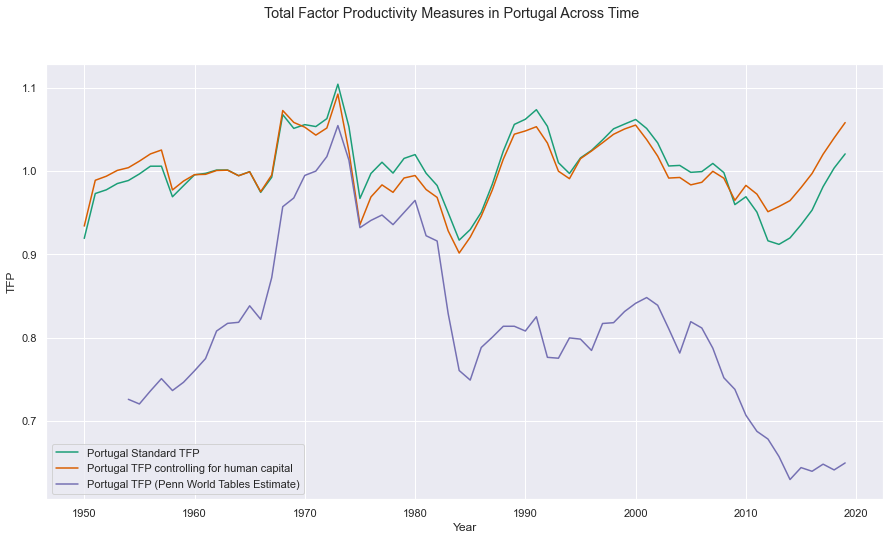

In [260]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=portugal_df["year"], y=portugal_tfp_stan, label="Portugal Standard TFP", ax=axes)
sns.lineplot(x=portugal_df["year"], y=portugal_tfp_hc, label="Portugal TFP controlling for human capital", ax=axes)
sns.lineplot(x=portugal_df["year"], y=portugal_df["ctfp"], label="Portugal TFP (Penn World Tables Estimate)", ax=axes)

axes.set_ylabel("TFP")
axes.set_xlabel("Year")
fig.suptitle("Total Factor Productivity Measures in Portugal Across Time")


#### South Africa TFP Measure

In [261]:
#calculating TFP for South Africa
south_africa_df = tfp_df.loc[tfp_df["country"] == "South Africa", ("country", "year", "rgdpna", "rnna", "hc", "emp",  "log_rgdpna", "log_rnna", "log_hc", "log_emp", "ctfp")]

#the two regressions, on the standard and human capital production functions
south_africa_log_tfp_hc = TFP_regression_human_capital(south_africa_df)
south_africa_log_tfp_stan = TFP_regression_standard(south_africa_df)


#obtaining an estimate for TFP rather than log TFP
south_africa_tfp_stan = np.exp(south_africa_log_tfp_stan)
south_africa_tfp_hc = np.exp(south_africa_log_tfp_hc)



Text(0.5, 0.98, 'Total Factor Productivity Measures in South Africa Across Time')

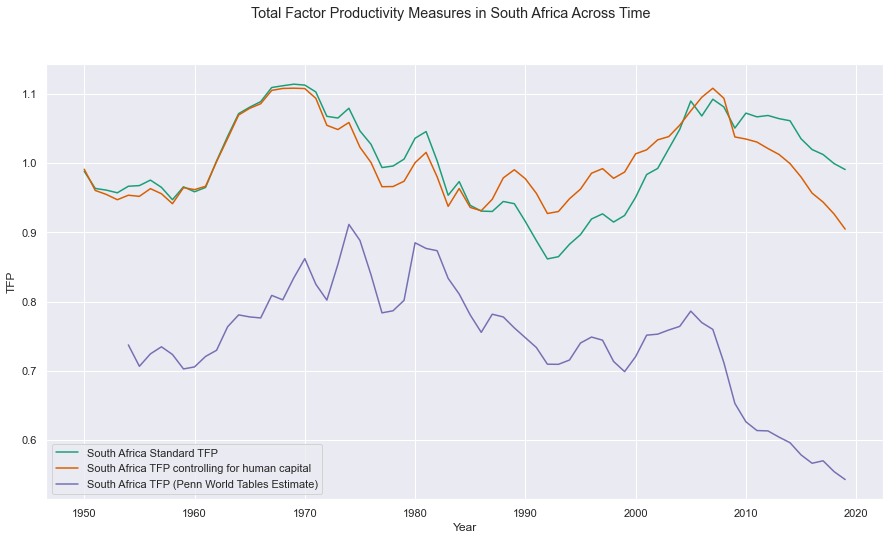

In [262]:
fig, axes = plt.subplots(1,1, sharex=True, figsize=(15,8))

sns.lineplot(x=south_africa_df["year"], y=south_africa_tfp_stan, label="South Africa Standard TFP")
sns.lineplot(x=south_africa_df["year"], y=south_africa_tfp_hc, label="South Africa TFP controlling for human capital")
sns.lineplot(x=south_africa_df["year"], y=south_africa_df["ctfp"], label="South Africa TFP (Penn World Tables Estimate)")


axes.set_ylabel("TFP")
axes.set_xlabel("Year")
fig.suptitle("Total Factor Productivity Measures in South Africa Across Time")


## Section 3: Growth Accounting

#### Our Key Equations
$y = Ak^\alpha$

$k_{t+1} = \gamma Ak_t^\alpha + (1-\delta)k_t$

We compute the contribution of technology ($A$) to growth as: $d \log(A) / d \log(Y)$ and of per capita capital ($k$) as: $\alpha d \log(k) / d\log(Y)$. 

## Section 4: Labour Productivity


In this section, we construct a series for labour productivity in our two countries, i.e. GDP per worker. 

We construct this series as follows: 

$$\text{labour productivity} = \frac Y L$$ 

where $Y$ represents real GDP, for which we use `rgdpna`, and $L$ represents the labour force, for which we use `emp`.

In [263]:
#constructing our series:

portugal_df["labour_product"] = portugal_df["rgdpna"] / portugal_df["emp"]
south_africa_df["labour_product"] = south_africa_df["rgdpna"] / south_africa_df["emp"]

Text(0.5, 0.98, 'Labour Productivity Over Time')

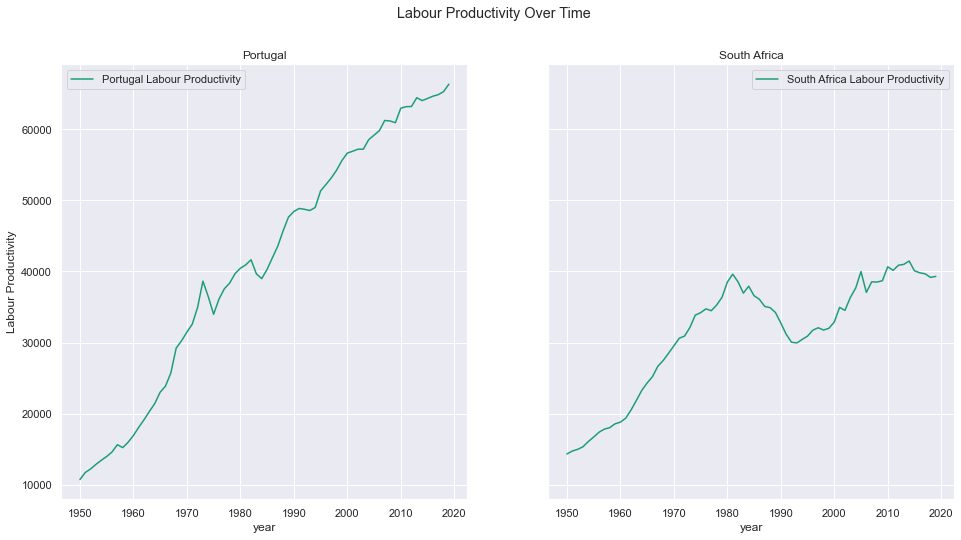

In [264]:
#plotting labour productivity in our countries
fig, axes = plt.subplots(1,2, sharey=True, figsize=(16,8))

sns.lineplot(x=portugal_df["year"], y=portugal_df["labour_product"], label="Portugal Labour Productivity", ax=axes[0])

sns.lineplot(x=south_africa_df["year"], y=south_africa_df["labour_product"], label="South Africa Labour Productivity",ax=axes[1])

axes[0].set_title("Portugal")
axes[1].set_title("South Africa")

axes[0].set_ylabel("Labour Productivity")

fig.suptitle("Labour Productivity Over Time")
